In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.model_build import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 64
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,image_fn
0,Bulbasaur,1,Grass,['1']
1,Ivysaur,2,Grass,['2']
2,Venusaur,3,Grass,['3']
3,Venusaur Gmax,3,Grass,['3_g']
4,Venusaur Mega,3,Grass,['3_2']
...,...,...,...,...
1113,Glastrier,896,Ice,['896']
1114,Spectrier,897,Ghost,['897']
1115,Calyrex,898,Psychic,['898_1']
1116,Calyrex Ice Rider,898,Psychic,['898_2']


- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


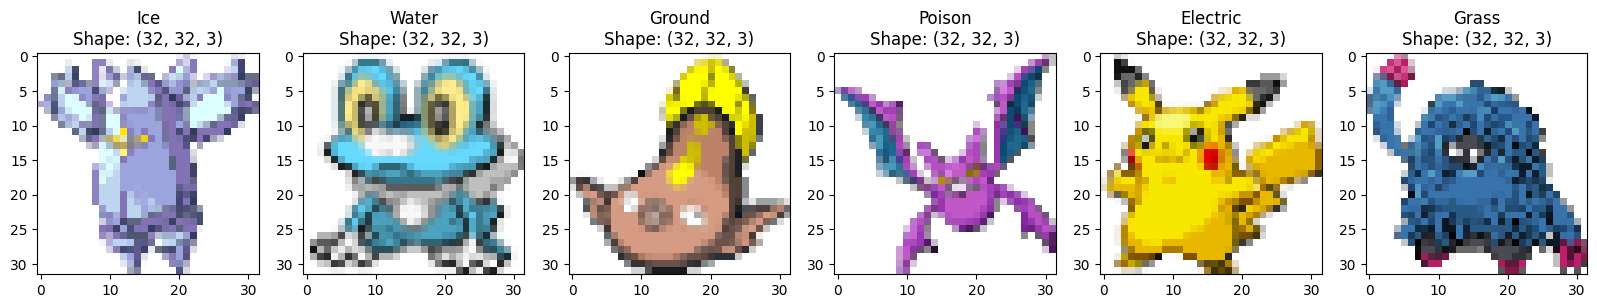

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, num_channels=128, embedding_dim=128)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1715201721.545432  117752 service.cc:145] XLA service 0x751dac002010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715201721.545464  117752 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715201722.143223  117752 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715201724.294616  117874 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1715201725.741974  117868 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1715201746.719565  117752 asm_compiler.cc:369] ptxas

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 201ms/step - loss: 0.9093
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.3434
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.2431
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.2057
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2178
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1839
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2263
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1879
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2004
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2250
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2513
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2141
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1235
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.2409
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1

Sampling sprite: 500it [00:31, 15.87it/s]                         


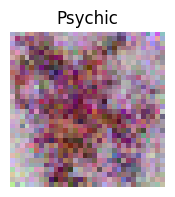

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 720ms/step - loss: 0.1940
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1412
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1571
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1509
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1969
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1127
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1032
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1896
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1165
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1681
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1232
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1816
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.1650
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1647
Epoch 34/100
27/63 ━━━━━━━━━━━━━━

In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1075
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1001
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1146
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1359
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1242
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1264
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0839
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0869
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1292
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.1104
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0908
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0799
Epoch 13/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0882
Epoch 14/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1371
Epoch 15/500
63/63 ━━━━━━━━━━

Sampling sprite: 500it [00:29, 17.04it/s]                         


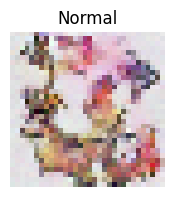

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - loss: 0.1372
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.1049
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1232
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1015
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0806
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1388
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1044
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.0969
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0751
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1038
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0680
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0801
Epoch 32/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1236
Epoch 33/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1076
Epoch 34/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:30, 16.13it/s]                         


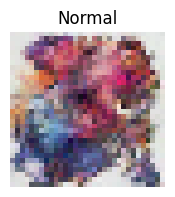

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - loss: 0.1197
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0904
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0754
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0703
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1201
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0705
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1005
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0933
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0998
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.1146
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.0962
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.0846
Epoch 52/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0922
Epoch 53/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0857
Epoch 54/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:28, 17.64it/s]                         


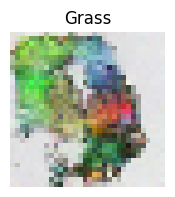

63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 667ms/step - loss: 0.0921
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0902
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1159
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1098
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0815
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1225
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0847
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1223
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0890
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0735
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1126
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1332
Epoch 72/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1224
Epoch 73/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1224
Epoch 74/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:29, 17.21it/s]                         


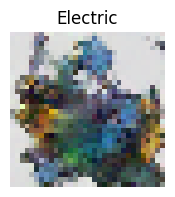

63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 677ms/step - loss: 0.1059
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1436
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1338
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1065
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1375
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0785
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0952
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1119
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1000
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0830
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1397
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1033
Epoch 92/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0969
Epoch 93/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1118
Epoch 94/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:28, 17.57it/s]                         


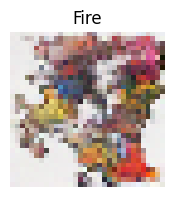

63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 668ms/step - loss: 0.1022
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0933
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0949
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0727
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1108
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0908
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0988
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0958
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0790
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1031
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0737
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1138
Epoch 112/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0831
Epoch 113/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1492
Epoch 114/500
63/63 

Sampling sprite: 500it [00:28, 17.52it/s]                         


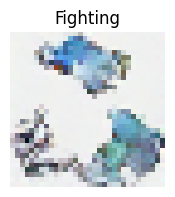

63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 671ms/step - loss: 0.0889
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1085
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1016
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0894
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1091
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1342
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1033
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0965
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0732
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1130
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0986
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0873
Epoch 132/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0703
Epoch 133/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0942
Epoch 134/500
63/63 

Sampling sprite: 500it [00:30, 16.34it/s]                         


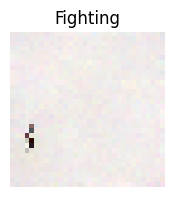

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 708ms/step - loss: 0.1129
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0892
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0970
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.1150
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0739
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0955
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1004
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0862
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.1099
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0629
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1129
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.1029
Epoch 152/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0951
Epoch 153/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0939
Epoch 154/500
63/63 

Sampling sprite: 500it [00:29, 17.22it/s]                         


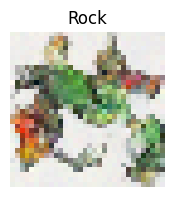

63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 680ms/step - loss: 0.0887
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0787
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1207
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1161
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1019
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1270
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0958
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0776
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1195
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1211
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0872
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.0868
Epoch 172/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0733
Epoch 173/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1133
Epoch 174/500
63/63 

Sampling sprite:  68%|██████▊   | 340/499 [00:20<00:09, 16.77it/s]

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 600
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

In [ ]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

[BACK TO TOP](#top)